In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


### Cuda device checking

In [2]:
device = ''
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"
print(f'Your device is "{device}"')

Your device is "cuda:0"


### Settings for reproducibility 

In [3]:
np.random.seed(17)
torch.manual_seed(13)

# Data:
## Define functions to 
  - load 
  - preprocess
  - check input data

In [4]:
x1 = np.load(r'data\train1\train\clean\20\20_205_20-205-0004.npy')
x2 = np.load(r'data\train1\train\clean\20\20_205_20-205-0012.npy')
x1.shape, x1.T.shape, x2.shape

((875, 80), (80, 875), (840, 80))

### Form a list of directories which contain train or val samples

In [5]:
train1_path, val_path = 'data/train1/train/', 'data/val/val/'

In [6]:
def get_clean_data_paths(path: str):
    """
    input: path to train or val dir with 'clean' and 'noise' dirs
    output: list of paths to clean data
    """
    clean = 'clean/'
    list_clean = []
    with os.scandir(path+clean) as entries:
        for entry in entries:
            if entry.is_dir():
                list_clean.append(entry.path)
    return sorted(list_clean)

def check_data_paths(paths_list, show_cnt = 10):
    """
    outputs number of input list elements and their values
    """
    print(f'input list length = {len(paths_list)}')
    for i, elem in enumerate(paths_list):
        print(elem)
        if i==show_cnt:
            break
    pass

In [7]:
#self checking and paths observation
tr_clean_paths_list = get_clean_data_paths(train1_path)
check_data_paths(tr_clean_paths_list)

input list length = 799
data/train1/train/clean/1006
data/train1/train/clean/102
data/train1/train/clean/104
data/train1/train/clean/1049
data/train1/train/clean/1051
data/train1/train/clean/1065
data/train1/train/clean/107
data/train1/train/clean/1085
data/train1/train/clean/1092
data/train1/train/clean/1094
data/train1/train/clean/1097


In [8]:
#self checking and paths observation
val_clean_paths_list = get_clean_data_paths(val_path)
check_data_paths(val_clean_paths_list)

input list length = 150
data/val/val/clean/1084
data/val/val/clean/1110
data/val/val/clean/1152
data/val/val/clean/1154
data/val/val/clean/1166
data/val/val/clean/1421
data/val/val/clean/149
data/val/val/clean/1572
data/val/val/clean/1593
data/val/val/clean/1680
data/val/val/clean/1685


### Load, transpose and check data

In [9]:
def get_data_from_clean_data_paths(clean_data_paths: list):
    """
    Loading numpy arrays situated on input list paths.
    input: paths to clean data
    output: loaded clean and noisy data to lists of np.ndarrays    
    """
    clean_data_list = []
    noisy_data_list = []

    #scans every dir path
    for path in clean_data_paths:
        #scans every file in current dir
        with os.scandir(path) as entries:
            for entry in entries:
                if entry.is_file():
                    clean_path = entry.path
                    noisy_path = entry.path.replace('clean', 'noisy',1)

                    clean_data_list.append(np.load(clean_path).T)
                    noisy_data_list.append(np.load(noisy_path).T)
    return clean_data_list, noisy_data_list

def check_loaded_data(data1_list, data2_list, check_part=0.1, check_shapes=True, print_shapes=False, check_data=False):
    """
    Help checking loaded data: if data from 2 lists has same shape and doesn't contain nans, zeros only and so on
    """
    
    cnt2check = int(max(1, len(data1_list)*check_part))
    samples2check = np.random.choice(range(len(data1_list)), cnt2check, replace=False)
    
    different_shape = False
    for index in samples2check:
        if data1_list[index].shape != data2_list[index].shape:
            different_shape = True
            print(f'Difference in shape is detected!'
                 f'\t{data1_list[index].shape} vs {data2_list[index].shape}')
            break
        if print_shapes:
            print(data1_list[index].shape)
    
    if check_data:
        for index in samples2check:
            print(f'mean1 = {np.mean(data1_list[index]):5.3}, std1 = {np.std(data1_list[index]):5.3}\t'
                  f'mean2 = {np.mean(data2_list[index]):5.3}, std2 = {np.std(data2_list[index]):5.3}')
        
def get_data_statistics(data):
    """
    Prints some data statistics and plots histogram of data lengths
    """
    dataLens = []
    for d in data:
        dataLens.append(d.shape[1])
    dataLens = np.array(dataLens)
    maxLen = np.max(dataLens)
    minLen = np.min(dataLens)
    meanLen = np.mean(dataLens)
    stdLen = np.std(dataLens)
    print(f'Data length params: min={minLen}, max={maxLen}, mean={meanLen}, std={stdLen}')
    plt.figure(figsize=(10,10))
    sns.histplot(data=dataLens)

In [10]:
#self checking and data observation
train_clean_data, train_noisy_data = get_data_from_clean_data_paths(tr_clean_paths_list[:])
check_loaded_data(train_clean_data, train_noisy_data, print_shapes=False)

In [11]:
len(train_clean_data), train_clean_data[0].shape

(12000, (80, 966))

In [12]:
val_clean_data, val_noisy_data = get_data_from_clean_data_paths(val_clean_paths_list[:])
check_loaded_data(val_clean_data, val_noisy_data, print_shapes=False)

Data length params: min=52, max=1374, mean=758.94225, std=246.37345585162137
Data length params: min=113, max=1226, mean=755.392, std=245.4581539407481


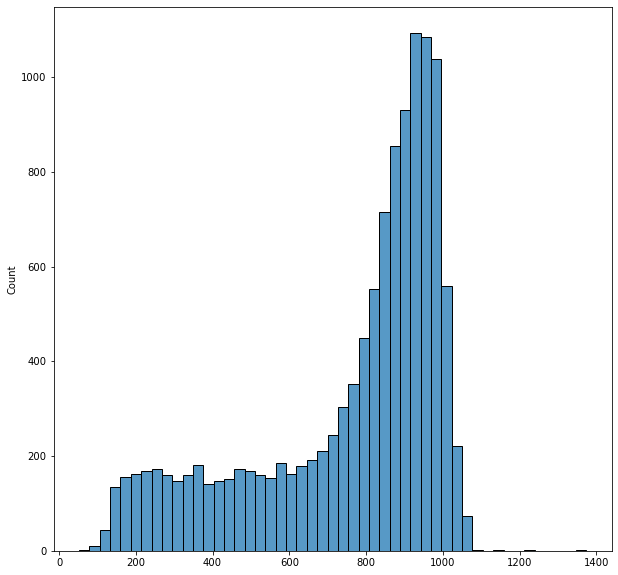

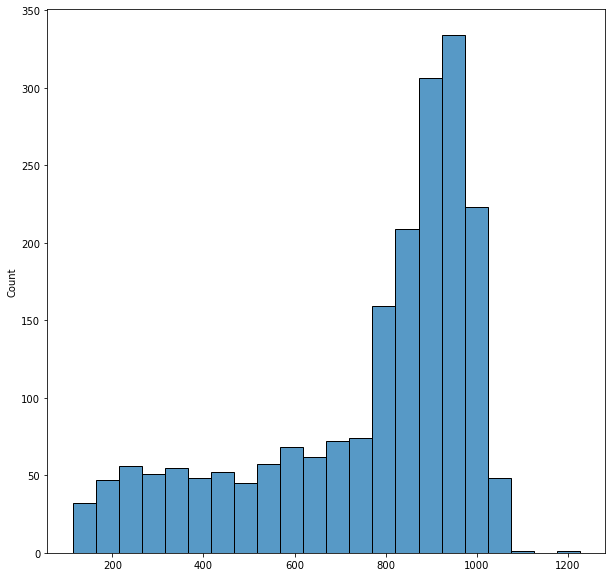

In [13]:
get_data_statistics(train_clean_data)
get_data_statistics(val_clean_data)

# Preparing training in PyTorch

### Training parameters

In [14]:
# batch size for training process
train_batch_size = 64
# batch size for evaluation process
dev_batch_size = 64
# part of train data for progress estimation
dev_part = 0.1
# max number of epochs
nEpochs = 100
# starting learning rate
learning_rate = 0.001

### We will use PyTorch functionality for batch construction:
  - custom Dataset class to store data with different sizes,
  - customized collate_fn to form batches of different shape elements in DataLoader.

In [15]:
class DetectionDS(Dataset):
    """
    Dataset class.
    Maintains
        data - clean and noisy data
        targets - target values for classification (0 - clean, 1 - noisy)
    """
    def __init__(self, clean, noisy):
        #initialize class object
        
        #concatenate clean and noisy data lists
        self.data = clean + noisy
        #generate corresponding targets
        self.targets = [0 for i in range(len(clean))] + [1 for i in range(len(noisy))]
        
    def __len__(self):
        #standard interface function for Dataset
        if self.data != None:
            return len(self.data)
        
    def __getitem__(self, idx):
        #standard interface function for Dataset
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = [self.data[idx], self.targets[idx]] #{'mel_data': self.data[idx], 'target': self.targets[idx]}
        return sample

In [16]:
def collate_function(batch):
    """
    A customization of default PyTorch collate_fn function
    Forms batch from items of different size:
        looks for min item length and then randomly 
        cuts parts of min length from each item
    """
    #extract data from input batch
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    
    min_len = 100000
    for elem in data:
        min_len = min(min_len, elem.shape[1])
    
    #slicing data to size of minimum element
    data = [random_cut(elem, min_len) for elem in data]
    
    return [torch.tensor(data).float(), torch.tensor(targets).float()]
        
    
def random_cut(array, slice_len):
    """
    Help function to randomly cut array through slicing
    """
    start_cut_range = array.shape[1] - slice_len
    random_start = np.random.randint(0, start_cut_range+1)

    return array[:, random_start: random_start+slice_len]    

In [17]:
def coherent_list_shuffle(list1, list2):
    """
    Shuffles 2 lists of the same length in coherent manner
    and returns them.
    It will help us to form random split train data to train and dev datasets
    """
    if len(list1) != len(list2):
        print('Error! Lengths of list1 and list2 must be the same!')
        return -1
    new_order = list(range(len(list1)))
    random.shuffle(new_order)
    new_list1 = [list1[new_order[i]] for i in new_order]
    new_list2 = [list2[new_order[i]] for i in new_order]
   
    return new_list1, new_list2

# l1 = list(range(10))
# l2 = list(range(10))
# l11,l22 = coherent_list_shuffle(l1, l2)
# print(f'{l11}\n{l22}')

In [18]:
def get_DataLoader(clean_data_list, noisy_data_list, batch_size):
    """
    Returns dataloaders for further training and evaluating
    Input:
        clean_data_list - list of numpy arrays with clean data
        noisy_data_list - list of numpy arrays with noisy data
        batch_size - defines batch size
    """
    dataset = DetectionDS(clean_data_list, noisy_data_list)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, 
                            collate_fn=collate_function, pin_memory=True)
    return dataloader

In [19]:
train_clean_data, train_noisy_data = coherent_list_shuffle(train_clean_data, train_noisy_data)

In [20]:
dev_data_length = int(len(train_clean_data)*dev_part)
train_data_length = len(train_clean_data) - dev_data_length

train_dataloader = get_DataLoader(train_clean_data[:train_data_length], 
                                  train_noisy_data[:train_data_length],
                                  train_batch_size)
dev_dataloader = get_DataLoader(train_clean_data[train_data_length:], 
                                train_noisy_data[train_data_length:],
                                dev_batch_size)

### Model definition
For noise classification problem we will use 10-convlayer VGG-like CNN with BatchNorm layers.

In [21]:
class BinaryNoiseClassification(nn.Module):
    """
    Model definition.
    Layers summary:
        There are 5 stages:
            1-3 stages consist of 2 Conv1d layers with ReLU -> MaxPool -> BatchNorm.
            4th stage consists of 2 Conv1d layers with ReLU -> BatchNorm -> GlobalMaxPool
            5th stage consists of 2 Fully-connected layers
    """
    def __init__(self):
        super(BinaryNoiseClassification, self).__init__()
        #VGG like architecture
        self.Conv1_1 = nn.Conv1d(in_channels=80, out_channels=64, kernel_size=3, padding=1)
        self.Conv1_2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.MaxPool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.BatchNorm1 = nn.BatchNorm1d(64)
        
        self.Conv2_1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.Conv2_2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.MaxPool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.BatchNorm2 = nn.BatchNorm1d(128)
        
        self.Conv3_1 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.Conv3_2 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.MaxPool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.BatchNorm3 = nn.BatchNorm1d(256)
        
        self.Conv4_1 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.Conv4_2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.BatchNorm4 = nn.BatchNorm1d(512)
        self.GloMaxPool1 = nn.AdaptiveMaxPool1d(output_size=1)
        
        self.Linear1 = nn.Linear(in_features=512, out_features=10)
        self.Linear2 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, inputs):
        #1st stage
        x = F.relu(self.Conv1_1(inputs))
        x = self.MaxPool1(F.relu(self.Conv1_2(x)))
        x = self.BatchNorm1(x)
        #2nd stage
        x = F.relu(self.Conv2_1(x))
        x = self.MaxPool2(F.relu(self.Conv2_2(x)))
        x = self.BatchNorm2(x)
        #3rd stage
        x = F.relu(self.Conv3_1(x))
        x = self.MaxPool3(F.relu(self.Conv3_2(x)))
        x = self.BatchNorm3(x)
        #4th stage
        x = F.relu(self.Conv4_1(x))
        x = self.GloMaxPool1(F.relu(self.Conv4_2(x)))
        x = self.BatchNorm4(x)
        #full conv stage
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.Linear1(x))
        x = self.Linear2(x)
        
        return x

In [22]:
model = BinaryNoiseClassification()
model.to(device)
print(model)

BinaryNoiseClassification(
  (Conv1_1): Conv1d(80, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (Conv1_2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (MaxPool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (BatchNorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Conv2_1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (Conv2_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (MaxPool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (BatchNorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Conv3_1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (Conv3_2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (MaxPool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (BatchNorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=Tru

### Auxiliary functions for training epoch and evaluating:

In [23]:
def Train(model, dataloader, device, epoch, learning_rate):
    """
    Computes 1 train epoch.
    Input: 
        model - training model, 
        dataloader - DataLoader with train data,
        device - chosen device,
        epoch - current epoch number
        learning_rate - learning rate for optimizer
    """
    model.train()
    criterion = nn.BCEWithLogitsLoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    running_loss = 0.0
    handled_samples = 0
    handled_samples_report_period = 4000
    next_report = handled_samples_report_period
    
    print("Train dataset statistics: ")
    for batch_number, data in enumerate(dataloader):
        samples, labels = data[0], data[1].unsqueeze_(1)
        samples, labels = samples.to(device) , labels.to(device)
        epoch_loss = 0
        epoch_acc = 0
        
        # forward + backward + optimize
        model.zero_grad()
        outputs = model(samples)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        handled_samples += labels.shape[0]
        if handled_samples >= next_report:
            print(f'epoch = {epoch:4}, handled samples = {handled_samples:5}, '
                  f'loss = {running_loss/handled_samples:5.3}')
            next_report += handled_samples_report_period
    
    torch.save(model.state_dict(), f'classifier_epoch{epoch}.pth')
    return running_loss/handled_samples

In [24]:
def Evaluate(model, dataloader, device):
    """
    Computes output for data in dataloader and returns loss and accuracy.
    Input: 
        model - trained model, 
        dataloader - DataLoader with evaluating data,
        device - chosen device
    """
    model.eval()
    criterion = nn.BCEWithLogitsLoss()
    predictions = None
    targets = None
    for batch_number, data in enumerate(dataloader):
        samples, labels = data[0], data[1].unsqueeze_(1)
        samples, labels = samples.to(device) , labels.to(device)

        if predictions is None:
            predictions = model(samples).cpu().detach().numpy()
            targets = labels.cpu().detach().numpy()
        else:        
            predictions = np.concatenate((predictions, model(samples).cpu().detach().numpy()), axis=0)
            targets = np.concatenate((targets, labels.cpu().detach().numpy()), axis=0)
    
    accuracy = binary_acc(predictions, targets)
    loss = criterion(torch.tensor(predictions), torch.tensor(targets)).item()
    print(f"\nEval dataset statistics: "
          f"eval_loss = {loss:5.3}, eval_accuracy = {accuracy:5.3}%\n")
    
    return loss, accuracy

def binary_acc(y_pred, y_test):
    """
    Calculates objective metric: Accuracy
    Input: 
        y_pred - model predictions, 
        y_test - ground truth
    """
    y_test, y_pred = torch.from_numpy(y_test).float(), torch.from_numpy(y_pred).float()
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float().item()
    acc = correct_results_sum/y_test.shape[0]
    acc = np.round(acc*100, 2)
    
    return acc

# Training classifier:

In [25]:
cur_learning_rate = learning_rate
best_model_epoch = 0
no_improve_epochs = 0
no_improve_epochs_to_stop = 3
best_dev_acuracy = 0.0

train_losses = []
dev_losses = []
dev_accuracies = []

for epoch in range(1, nEpochs+1):
    train_loss = Train(model, train_dataloader, device, epoch, cur_learning_rate)
    dev_loss, dev_accuracy = Evaluate(model, dev_dataloader, device)
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_accuracy)
    
    if dev_accuracy > best_dev_acuracy:
        best_dev_acuracy = dev_accuracy
        best_model_epoch = epoch
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs == no_improve_epochs_to_stop:
            print(f'Model stops improving on dev dataset!\n'
                  f'It is early stopping!\n'
                  f"Best model is saved as 'classifier_epoch{best_model_epoch}.pth'")
            break

Train dataset statistics: 
epoch =    1, handled samples =  4032, loss = 0.251
epoch =    1, handled samples =  8000, loss = 0.222
epoch =    1, handled samples = 12032, loss = 0.207
epoch =    1, handled samples = 16000, loss = 0.201
epoch =    1, handled samples = 20032, loss = 0.196

Eval dataset statistics: eval_loss = 0.171, eval_accuracy =  94.0%

Train dataset statistics: 
epoch =    2, handled samples =  4032, loss = 0.184
epoch =    2, handled samples =  8000, loss = 0.175
epoch =    2, handled samples = 12032, loss =  0.17
epoch =    2, handled samples = 16000, loss = 0.168
epoch =    2, handled samples = 20032, loss = 0.161

Eval dataset statistics: eval_loss =  0.17, eval_accuracy =  93.7%

Train dataset statistics: 
epoch =    3, handled samples =  4032, loss = 0.151
epoch =    3, handled samples =  8000, loss = 0.148
epoch =    3, handled samples = 12032, loss = 0.144
epoch =    3, handled samples = 16000, loss = 0.141
epoch =    3, handled samples = 20032, loss = 0.143



# Classifier evaluation
Loading best trained model and compute its loss and accuracy

In [31]:
loaded_classification_model = BinaryNoiseClassification()
model_state_dict = torch.load(f'classifier_epoch{best_model_epoch}.pth')
loaded_classification_model.load_state_dict(model_state_dict)
loaded_classification_model.to(device);

In [32]:
val_dataloader = get_DataLoader(val_clean_data, val_noisy_data, batch_size=1)

In [33]:
val_loss, val_accuracy = Evaluate(loaded_classification_model, val_dataloader, device)


Eval dataset statistics: eval_loss = 0.0544, eval_accuracy =  98.3%

